# OCR
 

## Imports

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd
import metric_orthograph as mo
import matplotlib.pyplot as plt

from doctr.models import ocr_predictor
from doctr.io import DocumentFile
# initialisation des variables globales
rss.init()



2023-02-21 21:03:13.451 INFO    root: TensorFlow version 2.11.0 available.
/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)
reload(mo)

<module 'metric_orthograph' from '/Users/jpec/Prog/OCRpyMAN/notebooks/metric_orthograph.py'>

# Utility

In [5]:
def load_image(filepath, resize=None):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=0)
    if resize:
        return tf.image.resize(im, resize)
    return im

def load_text_detection_model():
    DET_CKPT = "text_detection/straight_model/weights"
    straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
    straight_model.det_predictor.model.load_weights(DET_CKPT)
    return straight_model

def get_image_bounding_boxes(img_path):
    straight_model = load_text_detection_model()
    doc = DocumentFile.from_images(img_path)
    return straight_model.det_predictor(doc)[0]

def format_bounding_boxes(bounding_boxes, size = (1, 1)):
    return [ [bbox[0] * size[1], bbox[1] * size[0], bbox[2] * size[1], bbox[3] * size[0]] for bbox in bounding_boxes ]

def format_bounding_boxes_xyhw(bounding_boxes, size = (1, 1)):
    return [ [bbox[0] * size[1], bbox[1] * size[0], (bbox[3] - bbox[1]) * size[0], (bbox[2] - bbox[0]) * size[1]] for bbox in bounding_boxes ]

def plot_bounding_boxes(bounding_boxes):
    for bbox in bounding_boxes:
        xmin = bbox[0]
        ymin = bbox[1] 
        xmax = bbox[2] 
        ymax = bbox[3] 
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')

def plot_bounding_boxes_xyhw(bounding_boxes):
    for bbox in bounding_boxes:
        xmin = bbox[0] 
        ymin = bbox[1] 
        xmax = (bbox[3] + bbox[0])
        ymax = (bbox[2] + bbox[1])
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red')
        

# Code

## Text detection

In [6]:
form_img_path = '../data/formsA-D/a01-000u.png'
form_img = plt.imread(form_img_path)
img_size = (form_img.shape[0], form_img.shape[1])

doctr_bboxes = get_image_bounding_boxes(form_img_path)
bounding_boxes = format_bounding_boxes(doctr_bboxes, img_size)
bounding_boxes_xyhw = format_bounding_boxes_xyhw(doctr_bboxes, img_size)

2023-02-21 21:03:15.962 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-21 21:03:17.155 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


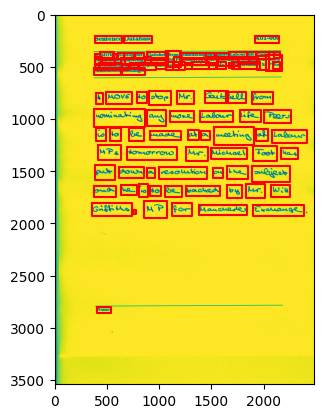

In [7]:
form_img = plt.imread(form_img_path)
size = form_img.shape[0], form_img.shape[1]
# plot_bounding_boxes_xyhw(bounding_boxes_xyhw)
plot_bounding_boxes(bounding_boxes)
plt.imshow(form_img)
plt.show()

### Testing with an image stream

In [8]:
# straight_model = load_text_detection_model()

# form_img_path = '../data/formsA-D/a01-000u.png'
# form_img = plt.imread(form_img_path)

# doc = DocumentFile.from_images(bytearray(form_img))
# doctr_coords = straight_model.det_predictor(doc)[0]
# doctr_coords

### Test with cropping

In [41]:
img_path = '../data/formsA-D/a01-000u.png'
doctr_bboxes = get_image_bounding_boxes(img_path)
img_arr = load_image(img_path)
img_size = (img_arr.shape[0], img_arr.shape[1])

bounding_boxes = format_bounding_boxes(doctr_bboxes, (1,1))
bounding_boxes_xyhw = format_bounding_boxes_xyhw(doctr_bboxes, (1,1))

2023-02-21 21:28:45.331 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-21 21:28:46.699 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


In [39]:
def reorder_bounding_boxes_coords():
    return []
bboxes = [[0.7919921875, 0.162109375,0.0146484375, 0.0546875,]]
list(map(lambda bbox: [bbox[1], bbox[0], bbox[2], bbox[3]], bboxes))

[[0.162109375, 0.7919921875, 0.0146484375, 0.0546875]]

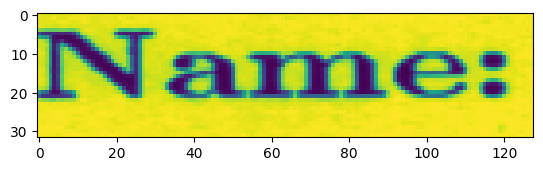

In [43]:
bboxes = [bounding_boxes[0]]
# bboxes = [bounding_boxes_xyhw[0]]
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)),
    # boxes=bboxes,
    crop_size=[32, 128], # To resize the crop (32, 128)
    box_indices=list(range(len(bboxes)))
)

for crop in crops:
    plt.imshow(crop)
    plt.plot()

### Multiple

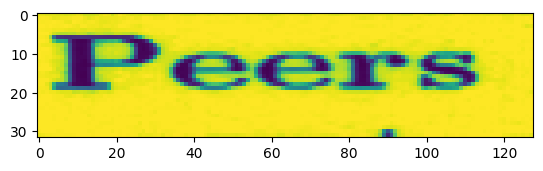

In [57]:
bboxes = bounding_boxes
crops = tf.image.crop_and_resize(
    tf.expand_dims(img_arr, 0),
    boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bboxes)), # [y1, x1, y2, x2]
    crop_size=[32, 128], # To resize the crop img to (32, 128)
    box_indices=[0 for i in range(len(bboxes))] # We are always using the same img
)

# fig = plt.figure(figsize = (10,20))
# nb_figs = len(crops)
# for i in range(nb_figs):
#     fig.add_subplot(1,nb_figs, i+1)
#     plt.imshow(crops[i])
# plt.plot()

i=0
for crop in crops[0: len(crops) - 5]:
    i += 1
    if i < 3:
        continue
    plt.imshow(crop)
    plt.plot()

## Text recognition

### POC

In [10]:
df = pd.read_pickle('../pickle/df.pickle')

[]

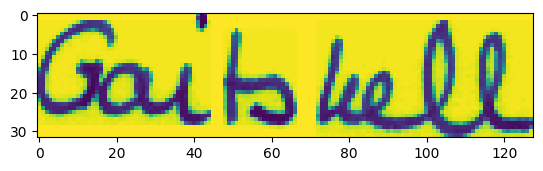

In [11]:
word_img_path = df.iloc[5].word_img_path
word_img = load_image(word_img_path, (32, 128));
plt.imshow(word_img);
plt.plot()

In [12]:
np.array([word_img]).shape

(1, 32, 128, 1)

In [13]:
reco_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})

In [14]:
# reco_predictions = reco_model.predict(np.array([word_img]))
reco_predictions = reco_model.predict(
    np.array(word_img).reshape(1,word_img.shape[0],word_img.shape[1],1)
)

1/1 [==============================] - 0s 104ms/step


/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [15]:
mots = ld_util.greedy_decoder(reco_predictions, rss.charList)
print(mots)

['']


# Full model

2023-02-21 21:36:16.221 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/db_resnet50-adcafc63.zip
2023-02-21 21:36:17.390 INFO    root: Using downloaded & verified file: /Users/jpec/.cache/doctr/models/crnn_vgg16_bn-76b7f2c6.zip


1/4 [======>.......................] - ETA: 0s

/Users/jpec/miniconda3/envs/work/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 86ms/step


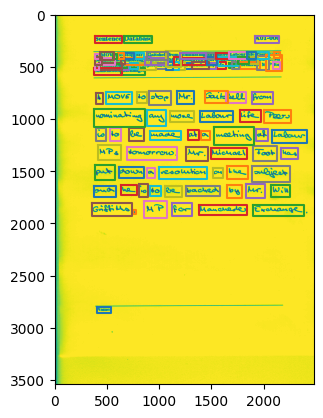

[['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '']]

In [50]:
def load_text_detection_model():
    DET_CKPT = "text_detection/straight_model/weights"
    straight_model = ocr_predictor(det_arch='db_resnet50', pretrained=True)
    straight_model.det_predictor.model.load_weights(DET_CKPT)
    return straight_model

def make_ocr(img_path, with_display = False):
    text_detection_model = load_text_detection_model()
    doc = DocumentFile.from_images(img_path)

    img_arr = load_image(img_path)
    img_size = (img_arr.shape[0], img_arr.shape[1])
    doctr_bboxes = text_detection_model.det_predictor(doc)[0]
    bounding_boxes = format_bounding_boxes(doctr_bboxes, (1,1))
    bounding_boxes_xyhw = format_bounding_boxes_xyhw(doctr_bboxes, img_size)

    box_texts = []

    recognition_model = tf.keras.models.load_model("../pickle/tj_ctc_augmented_20epochs_LR-plateau", custom_objects={"CTCLoss": mdl.CTCLoss})
    
    # https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize
    word_imgs = tf.image.crop_and_resize(
        tf.expand_dims(img_arr, 0),
        boxes=list(map(lambda bbox: [bbox[1], bbox[0], bbox[3], bbox[2]], bounding_boxes)), # [y1, x1, y2, x2] NORMALIZED
        crop_size=[32, 128], # To resize the crop img to (32, 128)
        box_indices=[0 for i in range(len(bounding_boxes))] # We are always using the same img
    )
    box_text_probs = recognition_model.predict(word_imgs) 
    box_text = ld_util.greedy_decoder(box_text_probs, rss.charList)
    box_texts.append(box_text)

    if with_display: 
        plt.imshow(img_arr)
        for bounding_box in bounding_boxes_xyhw:
            x = bounding_box[0]
            y = bounding_box[1]
            h = bounding_box[2]
            w = bounding_box[3]
            plt.plot([x, x+w, x+w, x, x], [y, y, y+h, y+h, y])
        plt.show()

    return box_texts

make_ocr(form_img_path, True)

# Thibault

In [ ]:
# df_detection = pd.DataFrame(bounding_boxes)
# df_detection = df_detection.drop(df_detection.columns[4], axis=1)
# df_detection.rename(columns = {0:'y',1:'x',2:'h',3:'w'}, inplace = True)
# df_detection.head()

# Création du dataset pour la reconnaissance du texte : TODO prend en parametre le retour du modele de détection de texte

# dataset = ld_util.get_dataset_for_prediction(file_path=form_img_path, coords=df_detection)


In [ ]:
#TEST affichage d'un mot depuis formulaire avec dataset

batch_id=0
iterator = iter(dataset)

x = iterator.get_next()
batch_id +=1
# rd.show_iterator_batch(x,'y',batch_id, 4)

lin = 11
col = 6
fig = plt.figure(figsize=(20,12))
    
img = x[1]

plt.imshow(img,cmap='gray')
# plt.title(str(i)+' : '+str(liste_label[i]))
plt.xticks([], [])
plt.yticks([], [])
plt.suptitle('Affichage du batch numéro '+str(batch_id), size = 20);

In [ ]:
# Utilisation du modele avec dataset formulaire
preds = model.predict(dataset)
mots = ld_util.greedy_decoder(preds, rss.charList)

print(mots)